<a href="https://colab.research.google.com/github/eunhaday/AIFFEL_quest_cr/blob/master/Exploration/SQUest24/exp03_1128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 169, in _make_candidate_from_dist
    base = self._installed_candidate_cache[dist.canonical_name]
KeyError: 'huggingface-hub'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/res

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py:   0%|          | 0.00/91.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/885M [00:00<?, ?B/s]

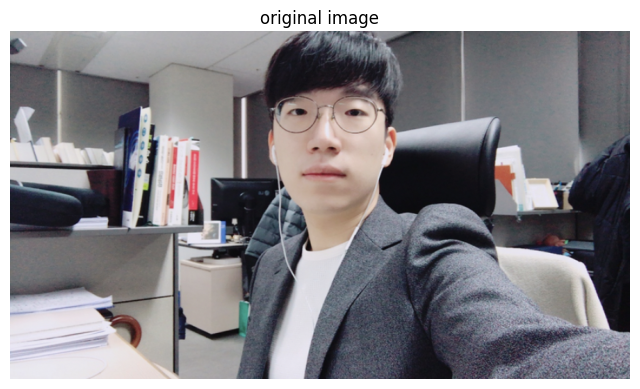

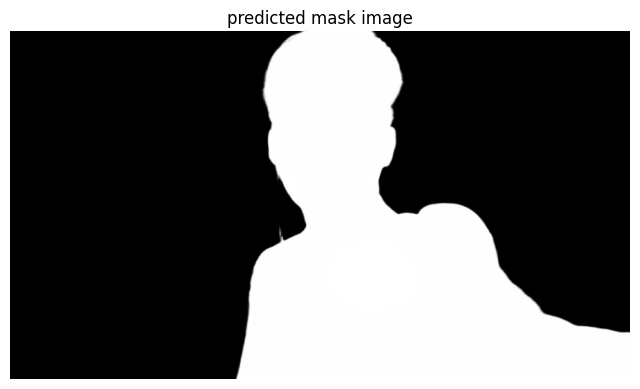

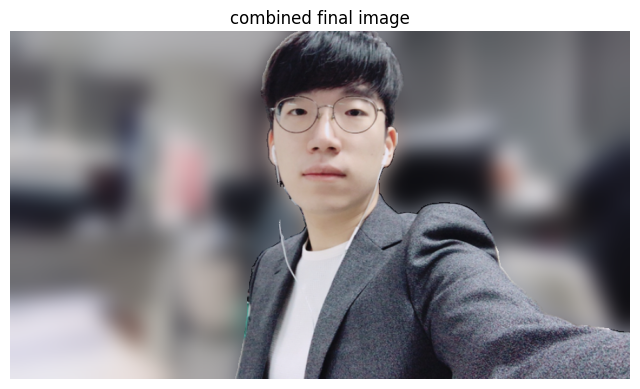

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install huggingface_hub
!pip install pillow
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install kornia


# Required Imports
from transformers import AutoImageProcessor, AutoModelForImageSegmentation
from PIL import Image
from torchvision import transforms
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = '/content/drive/MyDrive/my_image.png'

# 원본 이미지 로드 및 표시
original_image = Image.open(input_image_path).convert('RGB')
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('original image')
plt.axis('off')
plt.show()

# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)


# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BILINEAR)

# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image')
plt.axis('off')
plt.show()


# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.NEAREST)

# 마스크 이진화
mask_np = np.array(mask)
binary_mask = (mask_np > 0.5).astype(np.uint8) * 255
alpha_image = Image.fromarray(binary_mask, mode='L')

# 원본 이미지에 알파 채널 추가
image_rgba = image.convert('RGBA')
image_rgba.putalpha(alpha_image)

# 전경 이미지 추출
foreground_np = np.array(image_rgba)

# 배경 흐리게 처리
image_np = np.array(image.convert('RGB'))
blurred_background = cv2.GaussianBlur(image_np, (101, 101), 0)

# 알파 채널 추출
alpha_channel = binary_mask / 255.0
foreground_rgb = foreground_np[:, :, :3]

# 합성
combined = foreground_rgb * alpha_channel[:, :, np.newaxis] + blurred_background * (1 - alpha_channel[:, :, np.newaxis])
combined = combined.astype(np.uint8)

# 합성된 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(combined)
plt.title('combined final image')
plt.axis('off')
plt.show()

## Step 2. 사진에서 문제점 **찾기**

#### 새로운 모델로 해당 부분을 처리한 예시
#### 해당부분을 제거한 이미지가 상단의 이미지임.

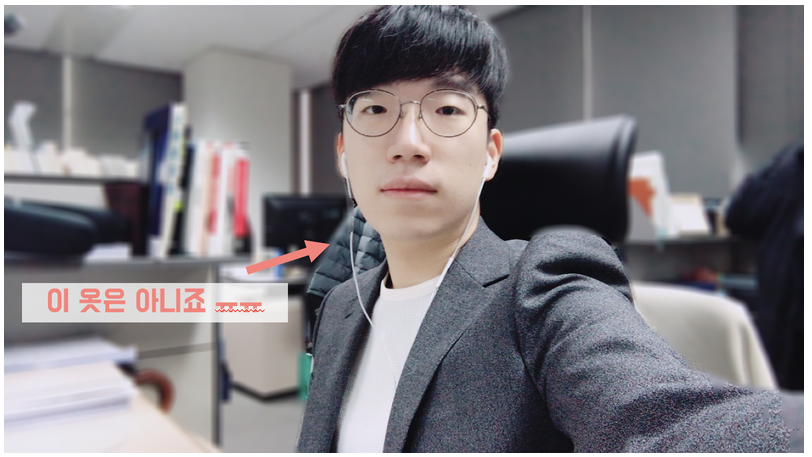

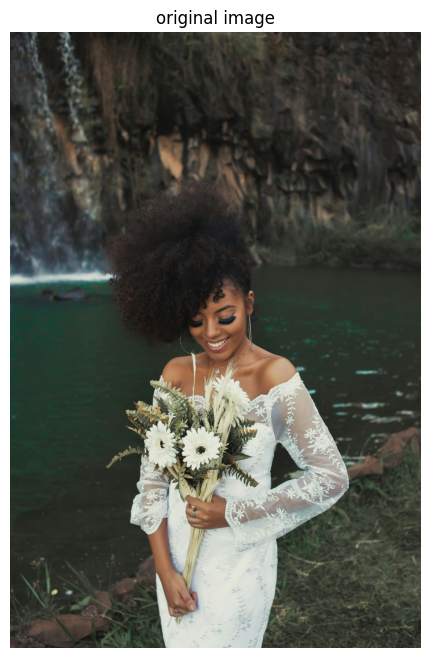

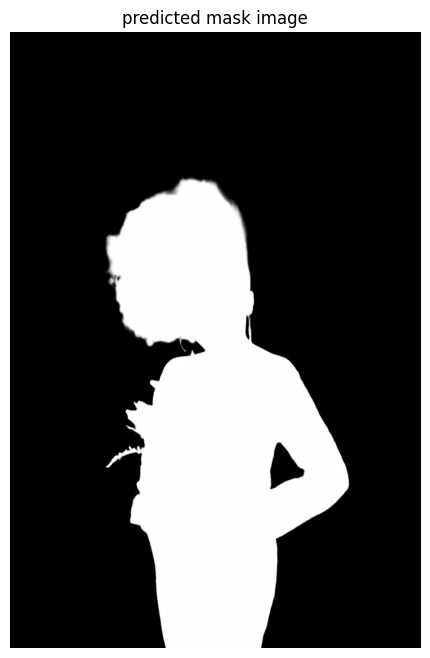

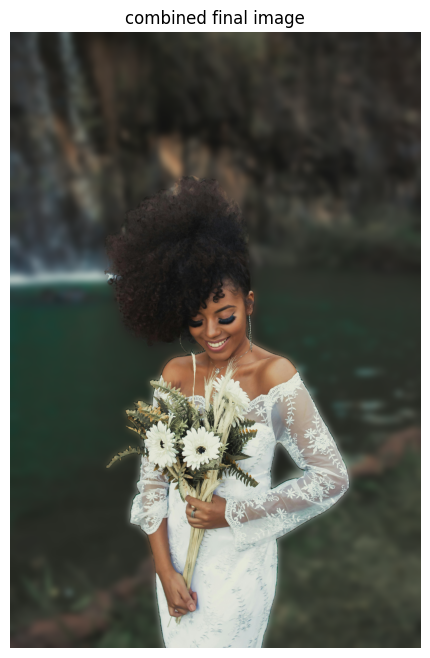

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

#!pip install transformers
#!pip install huggingface_hub
#!pip install pillow
#!pip install opencv-python
#!pip install torch
#!pip install torchvision
#!pip install kornia


# Required Imports
from transformers import AutoImageProcessor, AutoModelForImageSegmentation
from PIL import Image
from torchvision import transforms
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = '/content/drive/MyDrive/img1.jpg'


# 원본 이미지 로드 및 표시
original_image = Image.open(input_image_path).convert('RGB')
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('original image')
plt.axis('off')
plt.show()

# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)


# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BILINEAR)

# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image')
plt.axis('off')
plt.show()


# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.NEAREST)

# 마스크 이진화
mask_np = np.array(mask)
binary_mask = (mask_np > 0.5).astype(np.uint8) * 255
alpha_image = Image.fromarray(binary_mask, mode='L')

# 원본 이미지에 알파 채널 추가
image_rgba = image.convert('RGBA')
image_rgba.putalpha(alpha_image)

# 전경 이미지 추출
foreground_np = np.array(image_rgba)

# 배경 흐리게 처리
image_np = np.array(image.convert('RGB'))
#blurred_background = cv2.GaussianBlur(image_np, (101, 101), 0)
blurred_background = cv2.GaussianBlur(image_np, (201, 201), 0)  #크기는 홀수 정수여야 한다.

# 알파 채널 추출
alpha_channel = binary_mask / 255.0
foreground_rgb = foreground_np[:, :, :3]

# 합성
combined = foreground_rgb * alpha_channel[:, :, np.newaxis] + blurred_background * (1 - alpha_channel[:, :, np.newaxis])
combined = combined.astype(np.uint8)

# 합성된 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(combined)
plt.title('combined final image')
plt.axis('off')
plt.show()




#### 하단의 이미지가 인물의 중간에 있는 꽃부케 부분의 이미지가 중앙에 블러되어 보이는것으로 보면
*     배경으로 추출된 이미지의 한부분으로 보인다.
*     해당 이미지를 인물(사람)의 영역으로 처리되게 작업이 필요했다.
     모델을 변경후 다시 이미지를 불러와 처리시 상단의 그림처럼 인물의 영역으로 꽃부케가 같이 표시되는것을
     확인할 수 있다.

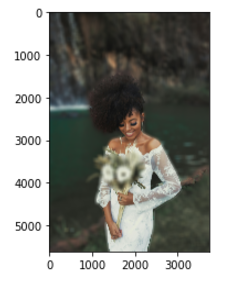

## Step 3. 해결 방법을 제안해 보기

#### 세그멘테이션의 한계를 노드5,6장에서 확인한거 같다.


### 1) Xception을 사용한 DeepLabv3+의 장점

* 정확성 :

아트러스 합성곱(확장 합성곱)을 통합하여 모델이 여러 스케일에서 특징을 포착하고 공간 해상도를 더 잘 보존할 수 있게 했습니다.
PASCAL VOC 및 COCO와 같은 대규모 데이터 세트에서 좋은 성과를 보입니다.


* 효율성 :

Xception을 백본으로 사용하여 깊이별 분리형 합성곱과 잔여 연결을 결합하여 기존 CNN(예: ResNet)에 비해 컴퓨팅 효율성이 높은 모델을 만듭니다.

* 상황 인식 :

ASPP(Atrous Spatial Pyramid Pooling) 모듈 은 다양한 확장률을 사용하여 아트루스 합성곱을 적용하여 문맥 정보를 수집하고, 이를 통해 모델이 복잡한 장면을 이해하는 능력을 향상시킵니다.

* 유연성 :

단일 이미지에서 여러 객체를 분할하여 의료 영상부터 자율 주행까지 다양한 응용 분야를 지원합니다.

* 사전 훈련된 모델 :

PASCAL VOC 및 Cityscapes와 같은 인기 있는 데이터세트에서 사전 훈련된 가중치를 사용하면 새로운 작업에 대한 세부 조정이 쉽습니다.



## 2) DeepLabv3+의 단점

* 에지 정밀도 :

머리카락 가닥이나 얇은 물체 경계와 같은 미세한 세부 사항을 분할하는 데 어려움이 있습니다. 이는 인물 사진 편집이나 의료 영상과 같이 픽셀 단위의 정밀도가 필요한 작업에 영향을 미칩니다.

* 높은 리소스 사용량 :

기존 아키텍처보다 효율적이기는 하지만, 특히 고해상도 이미지로 작업하는 경우 여전히 리소스를 많이 사용할 수 있습니다.

* 데이터 의존성 :

모델의 성능은 학습 데이터 세트의 품질과 다양성에 크게 좌우됩니다. 분포 밖 데이터에 대한 일반화가 잘 되지 않을 수 있습니다.

* 제한된 시간적 일관성 :

비디오 분할의 경우, DeepLabv3+는 본질적으로 시간적 일관성을 처리하지 않으므로 프레임 전체에서 일관되지 않은 결과가 발생합니다.

* 단일 작업 제한 :

의미론적 세분화만을 위해 설계되었습니다. 인스턴스 세분화 또는 파노라마 세분화를 결합한 멀티태스크 모델은 더 다재다능합니다.


## 3) DeepLabv3+의 개선 사항
한계점을 해결하려면:

* 경계 세분화 :
경계 정밀도를 개선하려면 CRF(조건부 난수 필드) 또는 에지 인식 손실을 사용합니다 .

* 후처리 :
분할된 마스크를 세부적으로 표현하기 위해 형태학적 연산 이나 블렌딩 기법을 적용합니다 .

* 하이브리드 모델 :
더 나은 깊이 인식 분할을 위해 DeepLabv3+를 깊이 추정 모델과 결합합니다.

## 4) 대안 또는 개선 사항
1. HRNet(고해상도 네트워크) :
네트워크 전체에 걸쳐 고해상도 표현을 유지합니다.
세부적인 사항과 개체 경계를 더 잘 보존합니다.
세로 분할과 같은 고정밀 작업에 적합합니다.

2. R-CNN 마스크 :
객체 감지와 인스턴스 분할을 결합합니다.
개별 객체에 대해 픽셀 단위까지 완벽한 마스크를 제공하므로 객체 분리가 중요한 작업에 이상적입니다.
계산량이 더 많지만 정확도는 더 높습니다.

3. Segment Anything 모델(SAM) :
Meta AI가 개발한 이 모델은 제로샷 방식으로 객체를 분할할 수 있습니다.
일반적인 용도의 세분화 작업에 매우 다재다능하고 정확합니다.
최소한의 미세 조정으로 보이지 않는 데이터에서도 잘 작동합니다.

4. 깊이 추정을 위한 MiDaS :
세분화와 깊이 추정을 결합하여 이미지의 깊이 계층을 이해함으로써 얕은 초점과 같은 자연스러운 효과를 생성합니다.
깊이 기반 분할은 배경 분리 정확도를 향상시킬 수 있습니다.

5. GAN 기반 접근 방식 :
Deep Image Matting 과 같은 모델은 GAN을 사용하여 특히 인물 사진 편집의 경우 세분화 결과를 개선합니다.
경계 정밀도를 개선하여 더욱 사실적인 결과를 생성할 수 있습니다.

6. U-Net 변형 :
Attention U-Net 이나 3D U-Net 과 같은 변형은 더 나은 기능 현지화를 위한 어텐션 메커니즘을 도입합니다.
고정밀 의료 영상 작업에 이상적입니다.


## 5) 추천 리소스 및 모델
* 텐서플로우 허브 :
다양한 데이터 세트와 애플리케이션에 최적화된 사전 학습된 DeepLabv3+ 모델입니다.
TensorFlow 허브 - DeepLab 모델


* 껴안는 얼굴 :
SAM과 같은 변압기 기반 모델을 포함한 최첨단 세분화 모델을 호스팅합니다.
허깅 페이스 모델

* PyTorch 허브 :
HRNet, Mask R-CNN 및 기타 최첨단 분할 아키텍처에 대한 액세스를 제공합니다.
파이토치 허브


##결론 >>  그중 허깅 페이스 모델로 해당부분을 처리하고 해소하는것으로 처리함


# 회고 :
* 노드에서 학습한 모델의 장단점을 확인하고, 해당 모델의 단점을 결국 해결하기 위한 시도로 추후 발전된 모델이 무엇이 있는지 찾아보는 과정이 노드의 본질인것 같다.
* 결국 문제를 해결하기 위한 노력으로 계속 모델들이 발전해오고 있는것으로 보인다.
* 그 모델의 사전학습된 모델을 사용해보고 문제를 해결하는 방법을 계속 숙지하고 처리해보는것이 데이터를 다루고 AI를 학습하는 사람들의 처리방법 인것 같다.